# LendingClub: Automating Lending Decisions
# Part 2. Grades, Subgrades and Interest Rates of Accepted Loans

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction     ](#toc1_)    
- 2. [Notebook and Data Preparation     ](#toc2_)    
- 3. [Exploratory Data Analysis     ](#toc3_)    
  - 3.1. [Identifying Features Related to Target Variables     ](#toc3_1_)    
  - 3.2. [Basic Data Understanding   ](#toc3_2_)    
  - 3.3. [Exporting Data for Model Development   ](#toc3_3_)    
  - 3.4. [Variable Relationships   ](#toc3_4_)    
  - 3.5. [Summary on Exploratory Data Analysis   ](#toc3_5_)    
- 4. [Statistical Inference on Joint Applications     ](#toc4_)    
  - 4.1. [Summary on Statistcial Inference  ](#toc4_1_)    
- 5. [Modeling     ](#toc5_)    
  - 5.1. [Grade Prediction     ](#toc5_1_)    
  - 5.2. [Subgrade     ](#toc5_2_)    
  - 5.3. [Interest Rate     ](#toc5_3_)    
  - 5.4. [Deployment  ](#toc5_4_)    
  - 5.5. [Summary on Modeling](#toc5_5_)    
- 6. [Recommendations     ](#toc6_)    
- 7. [Suggestions for Improvement](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction      [&#8593;](#toc0_)

LendingClub wants to automate their lending decisions fully and has provided old loan data from the middle of 2007 to the end of 2018 to build machine learning models for that. The process of lending automation is expected to happen in 3 steps:
1. loan classification into accepted and rejected;
2. prediction of the loan grade;
3. prediction of the loan subgrade and interest rate.

In this part, **steps 2 and 3** are addressed. Since grading is an ordered classification task, macro-averaged mean absolute error is tried to minimize to penalize misclassification of loan grades. Loan subgrade and interest prediction is the last step, which uses loan grades as an input. For subgrades, F1 score is the target metric, while root mean squared error is being minimized in interest rate prediction. The last 6 months of data is used for testing to better evaluate possible model's performance in the future. Validation is performed on the 6 months before the last 6 months.

The **aim** is to analyze accepted loans and provide insights on their grading and interest rates for the Lending Club.

The **objectives** are as follows:
* Explore the dataset to identify important features;
* Provide insights for joint loan applications;
* Build models to help automate loan grading as well as interest rate determination;
* Deploy models to the Google Cloud Platform.

## 2. <a id='toc2_'></a>Notebook and Data Preparation      [&#8593;](#toc0_)

Import libraries for data analysis, visualization and modelling. Set parameters for display.

In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars.selectors as cs
from scipy import stats
from helper_functions.ml_data_prep import (
    prepare_data_evaluation,
    X_y_spilt,
    stratified_sample,
)
from helper_functions import lc_data_utils
from sklearn.pipeline import Pipeline
from helper_functions.custom_model import (
    print_classification_results,
    print_regression_results,
    plot_shap_values,
)
from imblearn.metrics import macro_averaged_mean_absolute_error
import numpy as np
from datetime import datetime
from polars import col as c
import joblib
import phik
import warnings
import lightgbm as lgbm

# Display
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.labelsize": 11,
    "figure.figsize": (6, 4),
    "figure.autolayout": True,
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
    "legend.frameon": False,
    "axes.titlesize": "large",
    "figure.titlesize": "large",
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3, "future.no_silent_downcasting", True)
facecolor = sns.color_palette()[0]
emphasiscolor = sns.color_palette()[3]

%matplotlib inline
%config InlineBackend.figure_format = 'png'

Download and unzip the dataset in the `data` folder from the [storage](https://storage.googleapis.com/335-lending-club/lending-club.zip). The accepted loan table has 151 columns.

In [2]:
accepted_dataset_file = "./data/accepted_2007_to_2018Q4.csv"
loan_df = pl.read_csv(accepted_dataset_file, ignore_errors=True)
loan_df = loan_df.drop_nulls(subset=["id"])
loan_df = loan_df.rename({"issue_d": "date", "addr_state": "state"})
print(f"Number of columns in the accepted loan table: {loan_df.shape[1]}")

Number of columns in the accepted loan table: 151


All loan IDs are unique. There are no true duplicated in this dataset.

In [3]:
loan_df["id"].is_duplicated().sum()

0

A number of columns has a lot of data missing. These are mostly related to joint loans, or loans with hardships or debt settlement.

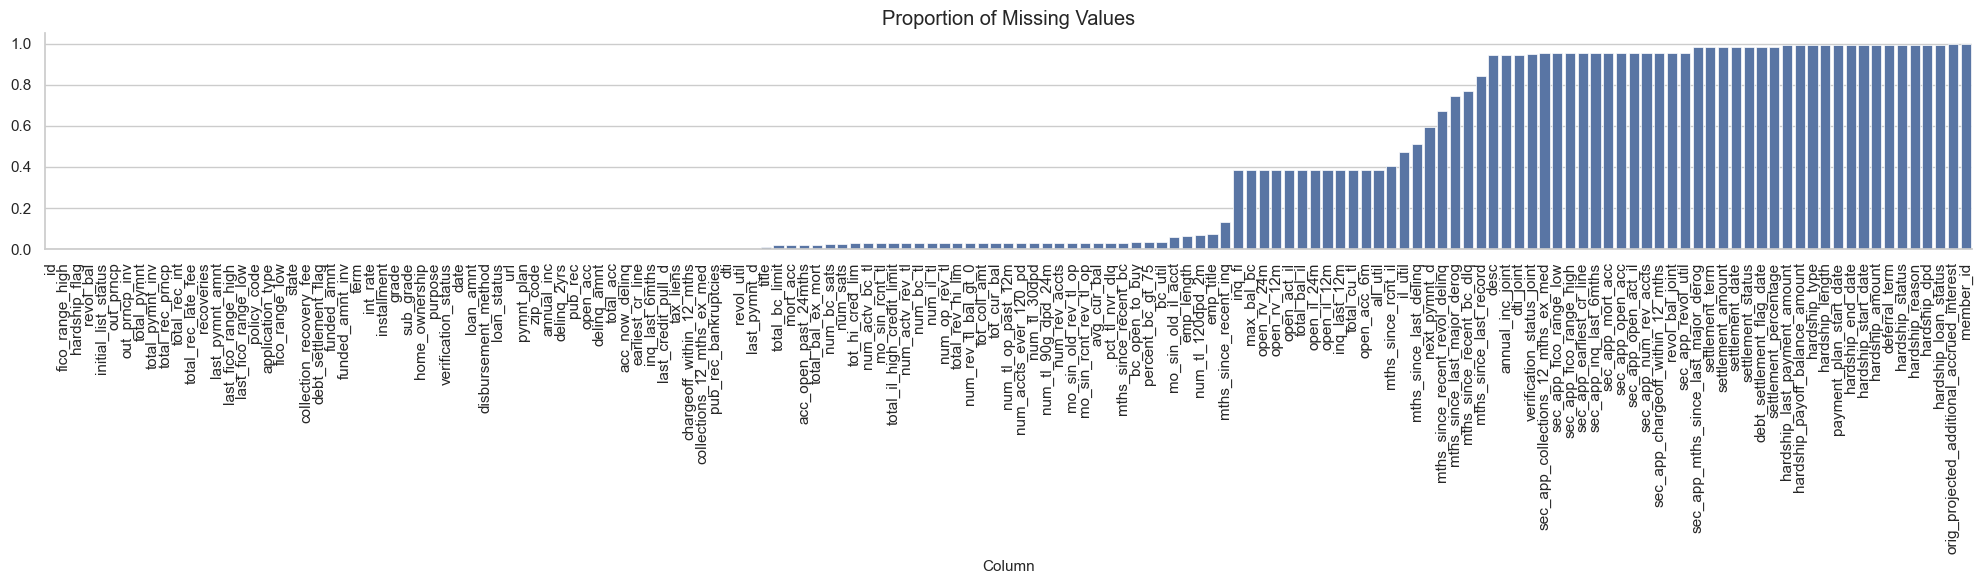

In [4]:
missing_per_column = (
    (loan_df.null_count() / loan_df.shape[0])
    .transpose(
        include_header=True, header_name="Column", column_names=["Missing"]
    )
    .to_pandas()
    .set_index("Column")
    .squeeze()
    .sort_values()
)
plt.figure(figsize=(20, 6))
sns.barplot(
    x=missing_per_column.index, y=missing_per_column.values, color=facecolor
)
plt.xticks(rotation=90)
plt.title("Proportion of Missing Values")
plt.show()

Some unrelevant columns or columns related to information unavailable at loan origination can be initially dropped. FICO scores is taken as a middle of the range. Correlated columns are also removed. Second applicant information and joint information are integrated for joint loans. After this initial step, 70 columns are left. For more details, see `lc_data_utils.py` file.

In [5]:
loan_df = lc_data_utils.initial_accepted_loan_cleaning(loan_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    loan_df = lc_data_utils.joint_loan_integration(loan_df)
print(f"Number of columns in the accepted loan table: {loan_df.shape[1]}")

Number of columns in the accepted loan table: 70


As mentioned, for the further analysis the last 6 months are not used.

In [6]:
data_eda = loan_df.filter(c.date <= datetime(2018, 6, 1))

## 3. <a id='toc3_'></a>Exploratory Data Analysis      [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Identifying Features Related to Target Variables      [&#8593;](#toc0_)

To make the task easier, a rough subset of features is selected based on correlation with target variables `grade`, `sub_grade`, `int_rate`. Balanced sample is used having equal numbers of all subgrades. Only features with at least 0.1 $\phi_K$ correlation coefficient with at least a single target variable is selected.

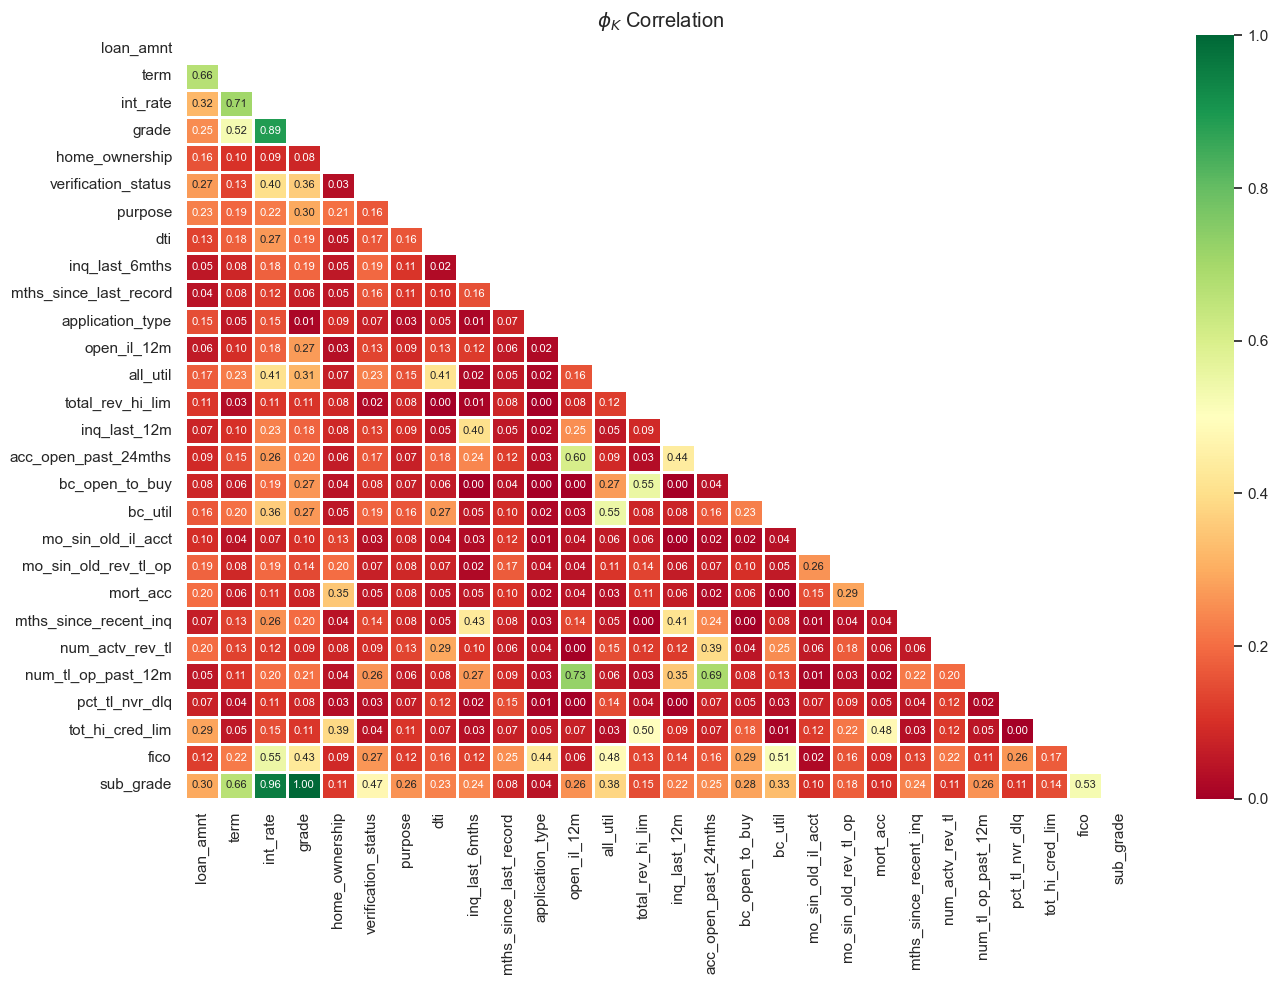

Number of selected columns (with targets): 28


In [7]:
subsample = lc_data_utils.sample_balanced_pandas(
    data_eda.drop(columns="date").to_pandas(), target="sub_grade"
)
num_features = subsample.select_dtypes(include="number")
phik_corr = subsample.phik_matrix(interval_cols=num_features)
targets = ["grade", "sub_grade", "int_rate"]
selected_columns = [
    col for col in phik_corr.columns if any(phik_corr[col][targets] > 0.1)
]
subsample = subsample[selected_columns]
num_features = subsample.select_dtypes(include="number")
phik_corr = subsample.phik_matrix(interval_cols=num_features)
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
plt.figure(figsize=(14, 10))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    annot_kws={"size": 8},
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("$\phi_K$ Correlation")
plt.grid(False)
plt.show()
print(f"Number of selected columns (with targets): {len(selected_columns)}")

### 3.2. <a id='toc3_2_'></a>Basic Data Understanding    [&#8593;](#toc0_)

The following are unique categories of each categorical column.

In [8]:
for col in data_eda.columns:
    if data_eda[col].dtype == pl.Categorical:
        unique_count = data_eda[col].n_unique()
        unique_values = data_eda[col].unique().sort().to_list()
        print(f"{col}: {unique_count} unique categories - {unique_values}")
grade_labels = data_eda["grade"].unique().sort().to_list()
subgrade_labels = data_eda["sub_grade"].unique().sort().to_list()

term: 2 unique categories - ['36 months', '60 months']
grade: 7 unique categories - ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sub_grade: 35 unique categories - ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
home_ownership: 4 unique categories - ['MORTGAGE', 'RENT', 'OWN', 'OTHER']
verification_status: 3 unique categories - ['Not Verified', 'Source Verified', 'Verified']
purpose: 14 unique categories - ['debt_consolidation', 'small_business', 'home_improvement', 'major_purchase', 'credit_card', 'other', 'house', 'vacation', 'car', 'medical', 'moving', 'renewable_energy', 'wedding', 'educational']
state: 51 unique categories - ['PA', 'SD', 'IL', 'NJ', 'GA', 'MN', 'SC', 'RI', 'TX', 'NC', 'CA', 'VA', 'AZ', 'NY', 'IN', 'MD', 'KS', 'NM', 'AL', 'WA', 'MO', 'OH', 'LA', 'FL', 'CO', 'MI', 'TN', 'DC', 'MA', 'WI', 'HI', 'VT', 'DE', 'NH', 'NE'

Most of the loans are individual loans and more often taken for 3 year-period instead of 6. Verification status do not differ much between loans. Most applicants have a mortgage or rent a home.

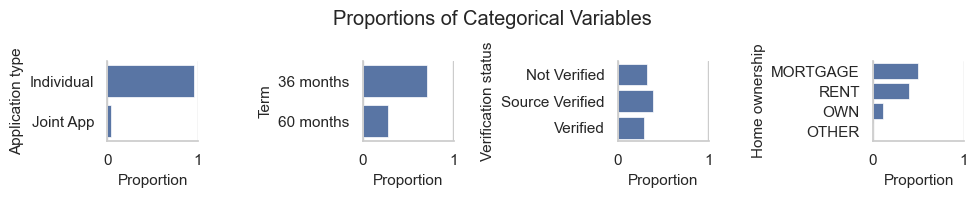

In [9]:
cat_features = [
    "application_type",
    "term",
    "verification_status",
    "home_ownership",
]
fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharex="all")
axes = axes.flatten()
for idx, col in enumerate(cat_features):
    sns.countplot(data=data_eda, y=col, stat="proportion", ax=axes[idx])
    axes[idx].set(
        ylabel=col.replace("_", " ").capitalize(), xlabel="Proportion"
    )
fig.suptitle("Proportions of Categorical Variables")
plt.show()

Lending Club loans are mostly taken in order to consolidate debts. The 2nd most popular loan purpose is credit card refinancing. A very small number of loans is taken for wedding, renewable energy or education.

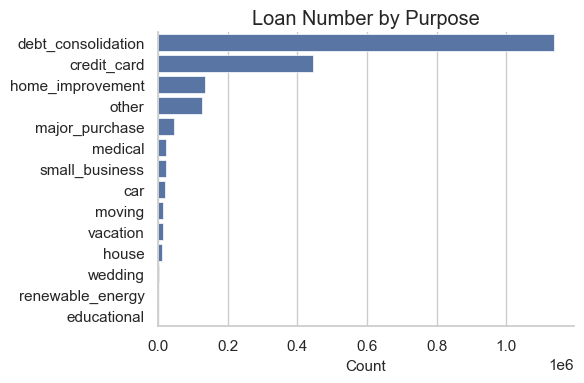

In [10]:
order = (
    data_eda["purpose"]
    .value_counts()
    .sort("count", descending=True)["purpose"]
    .to_list()
)
ax = sns.countplot(data=data_eda, y="purpose", order=order, stat="count")
ax.set(xlabel="Count", ylabel=None, title="Loan Number by Purpose")
plt.show()

Most of selected numerical columns have very skewed distribution. These skewed features are mostly related to the number of months since some particular event, o number of events happening in a particular time period, or count of accounts or trades.

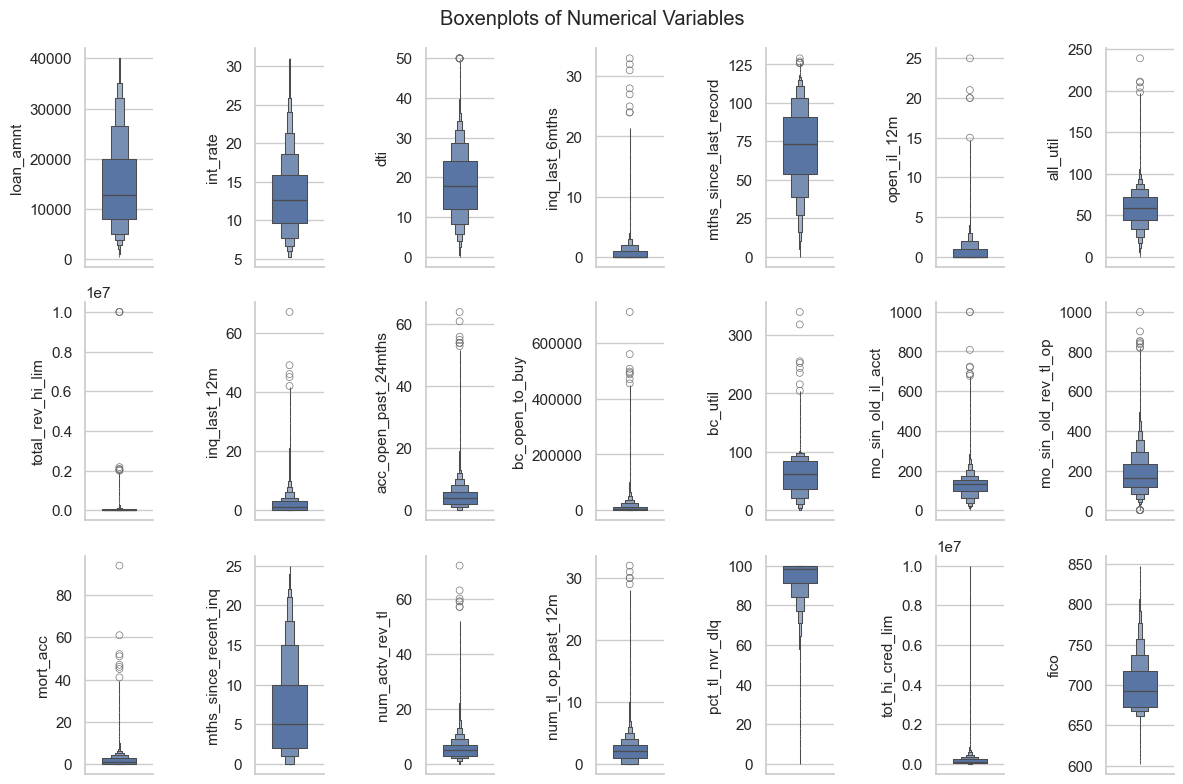

In [11]:
fig, axes = plt.subplots(3, 7, figsize=(12, 8))
axes = axes.flatten()
for idx, col in enumerate(num_features):
    sns.boxenplot(data=data_eda, y=col, ax=axes[idx], width=0.5)
    axes[idx].set(ylabel=col, xlabel=None)
fig.suptitle("Boxenplots of Numerical Variables")
plt.show()

Months since oldest bank installment account opened (`mo_sin_old_il_acct`) and months since oldest revolving account opened (`mo_sin_old_rev_tl_op`) seem to have outliers encoded as 999. To cap those a maximum number of 75 years is selected. Also total high credit/credit limit (`tot_hi_cred_lim`) seems to have outliers encoded as 9999999.

In [12]:
data_eda.select(num_features).describe()

describe,loan_amnt,int_rate,dti,inq_last_6mths,mths_since_last_record,open_il_12m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,mths_since_recent_inq,num_actv_rev_tl,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,fico
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.004062e6,2.004062e6,2.004061e6,2.004032e6,327999.0,1.137933e6,1.13778e6,1.933786e6,1.137932e6,1.954032e6,1.932465e6,1.931441e6,1.87408e6,1.933785e6,1.954032e6,1.74069e6,1.933786e6,1.933786e6,1.933632e6,1.933786e6,2.004062e6
"""null_count""",0.0,0.0,1.0,30.0,1.676063e6,866129.0,866282.0,70276.0,866130.0,50030.0,71597.0,72621.0,129982.0,70277.0,50030.0,263372.0,70276.0,70276.0,70430.0,70276.0,0.0
"""mean""",14920.727839,13.111977,18.165688,0.606607,71.039521,0.675939,57.642437,33980.471353,2.071075,4.538107,10896.06589,58.891421,126.075695,182.535071,1.585279,6.954536,5.655552,2.085413,94.046892,177036.017615,698.849082
"""std""",9056.245503,4.779058,8.36879,0.906599,26.514758,0.925164,20.904931,36607.872431,2.399348,3.157659,16094.844724,28.408356,52.981614,96.663268,1.923434,5.945851,3.373448,1.824235,9.035771,180151.796042,32.287722
"""min""",500.0,5.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,602.0
"""25%""",8000.0,9.67,11.9,0.0,54.0,0.0,44.0,14400.0,0.0,2.0,1612.0,36.8,97.0,117.0,0.0,2.0,3.0,1.0,91.2,50458.0,672.0
"""50%""",12800.0,12.62,17.7,0.0,73.0,0.0,59.0,25000.0,1.0,4.0,5129.0,61.6,130.0,165.0,1.0,5.0,5.0,2.0,98.2,113846.0,692.0
"""75%""",20000.0,15.88,24.08,1.0,91.0,1.0,72.0,42300.0,3.0,6.0,13431.0,84.0,153.0,233.0,3.0,10.0,7.0,3.0,100.0,255900.0,717.0
"""max""",40000.0,30.99,49.96,33.0,129.0,25.0,239.0,9.999999e6,67.0,64.0,711140.0,339.6,999.0,999.0,94.0,25.0,72.0,32.0,100.0,9.999999e6,848.0


### 3.3. <a id='toc3_3_'></a>Exporting Data for Model Development    [&#8593;](#toc0_)

The mentioned outliers are encoded as missing values.

In [13]:
loan_df = loan_df.select(selected_columns + ["date"])
loan_df = loan_df.with_columns(
    mo_sin_old_rev_tl_op=pl.when(c.mo_sin_old_rev_tl_op > 75 * 12)
    .then(None)
    .otherwise(c.mo_sin_old_rev_tl_op),
    mo_sin_old_il_acct=pl.when(c.mo_sin_old_il_acct > 75 * 12)
    .then(None)
    .otherwise(c.mo_sin_old_il_acct),
    tot_hi_cred_lim=pl.when(c.tot_hi_cred_lim > 9.9e6)
    .then(None)
    .otherwise(c.tot_hi_cred_lim),
)

Data are split into training, validation and testing sets. Validation and testing sets take the last two half-years. EDA is performed on the training and validation sets only. 

In [14]:
loan_df = loan_df.with_columns(
    grade_enc=c.grade.rank("dense").cast(pl.Int8) - 1,
    sub_grade_enc=c.sub_grade.rank("dense").cast(pl.Int8) - 1,
)  # encoding to enable macro averaged MAE calculation
data_train = loan_df.filter(c.date <= datetime(2017, 12, 1)).to_pandas()
data_train_balanced = lc_data_utils.sample_balanced_pandas(
    data_train, target="sub_grade"
)
data_val = loan_df.filter(
    c.date.is_between(datetime(2018, 1, 1), datetime(2018, 6, 1))
).to_pandas()
data_test = loan_df.filter(c.date >= datetime(2018, 7, 1)).to_pandas()
drop_cols = ["date"]
dfs = [data_train, data_train_balanced, data_val, data_test]
titles = ["data_train", "data_train_balanced", "data_val", "data_test"]
for d, t in zip(dfs, titles):
    print(
        f"The number of instances in {t} is {d.shape[0]}, it is"
        f" {d.shape[0]/loan_df.shape[0]:.1%} of all accepted loans."
    )
    d.drop(columns=drop_cols).to_pickle(f"./data/{t}_mod2.pkl")

The number of instances in data_train is 1765426, it is 78.1% of all accepted loans.
The number of instances in data_train_balanced is 53935, it is 2.4% of all accepted loans.
The number of instances in data_val is 238636, it is 10.6% of all accepted loans.
The number of instances in data_test is 256606, it is 11.4% of all accepted loans.


The distribution of subgrades seems relatively similar between sets. However A1 loans are more common in test set, while E, F, and G loans more common in training set. Overall, worse-quality loans are quite uncommon as well as high interest rates.

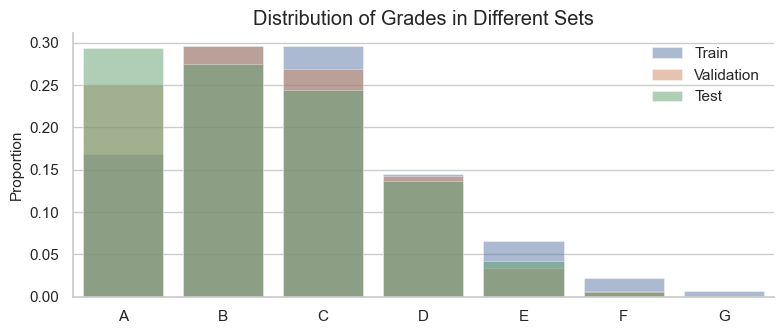

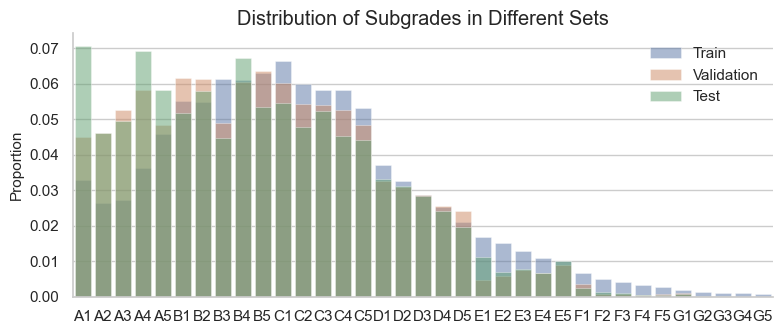

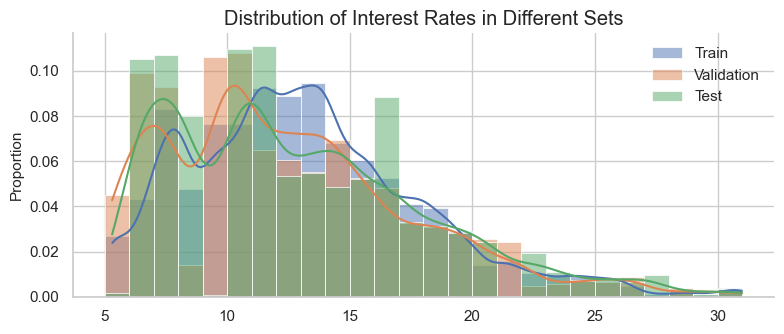

In [15]:
dfs = [data_train, data_val, data_test]
labels = ["Train", "Validation", "Test"]
titles = ["Grades", "Subgrades", "Interest Rates"]
for target, title in zip(targets, titles):
    plt.figure(figsize=(8, 3.5))
    if target == "int_rate":
        params = {
            "stat": "proportion",
            "alpha": 0.5,
            "binwidth": 1,
            "binrange": [5, 31],
            "kde": True,
            "kde_kws": {"bw_adjust": 2},
        }
        for df, label in zip(dfs, labels):
            sns.histplot(data=df, x=target, label=label, **params)
            plt.legend()
    else:
        params = {
            "stat": "proportion",
            "alpha": 0.5,
            "order": loan_df[target].unique().sort().to_list(),
        }
        for df, label in zip(dfs, labels):
            sns.countplot(data=df, x=target, label=label, **params)
    plt.ylabel("Proportion")
    plt.xlabel("")
    plt.title(f"Distribution of {title} in Different Sets")
    plt.show()

### 3.4. <a id='toc3_4_'></a>Variable Relationships    [&#8593;](#toc0_)

Some small modifications for better visuals.

In [16]:
data_eda = loan_df.filter(c.date <= datetime(2018, 6, 1))
data_eda = data_eda.rename({
    "int_rate": "Interest Rate",
    "grade": "Grade",
    "sub_grade": "Subgrade",
    "dti": "Debt-to-Income",
    "fico": "FICO",
    "loan_amnt": "Loan Amount",
    "all_util": "Balance-to-Limit",
    "term": "Term",
    "purpose": "Purpose",
    "verification_status": "Verification Status",
    "application_type": "Application Type",
})
data_eda = data_eda.with_columns(
    c.Purpose.str.replace("_", " ").str.to_titlecase()
)

The median of interest rate gradually increases with lower loan subgrade since higher risk loans are charged more.

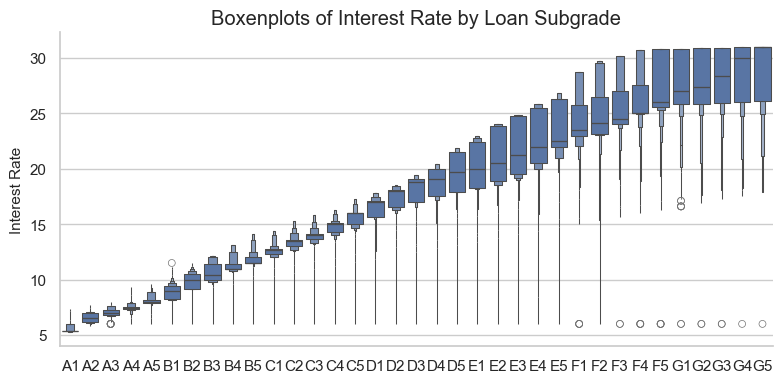

In [17]:
plt.figure(figsize=(8, 4))
ax = sns.boxenplot(
    data=data_eda, x="Subgrade", y="Interest Rate", order=subgrade_labels
)
ax.set(
    title="Boxenplots of Interest Rate by Loan Subgrade",
    xlabel="",
)
plt.show()

Interest rate seems strongly determined by FICO, debt-to-income ratio and bankcard balance-to-limit ratio. Smaller interest rates are common with shorter loans, but this is mostly dictated by loan amount. On the other hand, FICO, debt-to-income ratio and balance-to-limit ratio are distributed similarly between short-term and long-term loans.

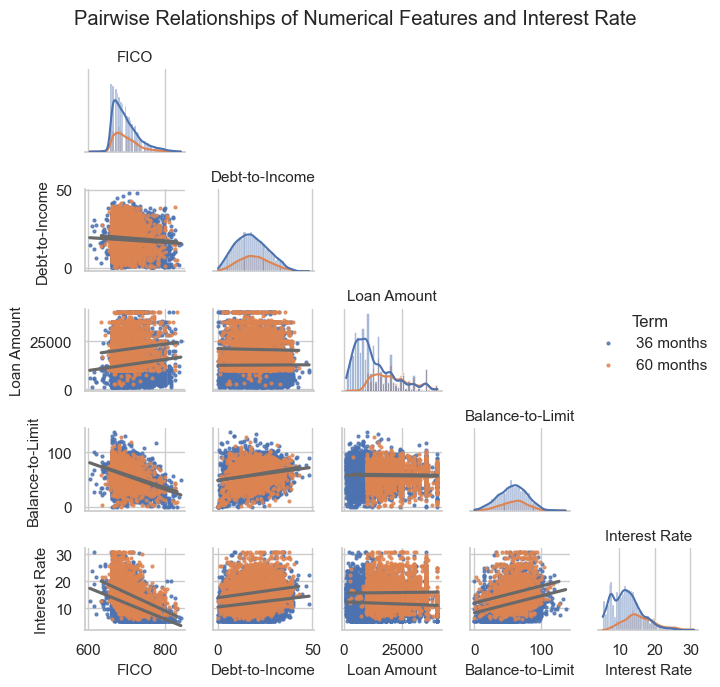

In [18]:
def diag_title(x, **kws):
    plt.gca().set_title(x.name, size=11)


cols = [
    "FICO",
    "Debt-to-Income",
    "Loan Amount",
    "Balance-to-Limit",
    "Interest Rate",
    "Term",
]
g = sns.PairGrid(
    data=data_eda.sample(n=1e4, seed=42).select(cols),
    corner=True,
    hue="Term",
)
g.map_diag(sns.histplot, kde=True)
g.map_diag(diag_title)
g.map_lower(sns.regplot, scatter_kws={"s": 4}, line_kws={"color": "dimgrey"})
g.figure.suptitle(
    "Pairwise Relationships of Numerical Features and Interest Rate",
)
g.figure.set_size_inches(6, 7)
g.add_legend()
plt.show()

Interest rates are quite similar for different-purpose loans. The lowest median interest rate is for credit card refinancing, the highest - for small business. Seems that taking a joint loan for small business may help in lowering the interest rate.

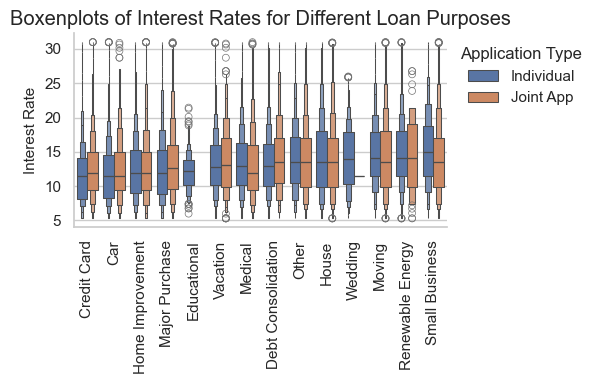

In [19]:
order = (
    data_eda.group_by("Purpose")
    .agg(pl.col("Interest Rate").median())
    .sort("Interest Rate")["Purpose"]
    .to_list()
)
ax = sns.boxenplot(
    data=data_eda,
    x="Purpose",
    y="Interest Rate",
    order=order,
    hue="Application Type",
)
ax.set(
    title="Boxenplots of Interest Rates for Different Loan Purposes", xlabel=""
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

Quite surprisingly, the median interest rate is slightly lower for applicants without verified income source.

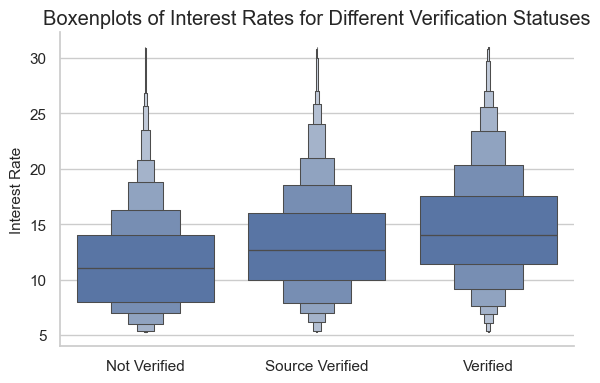

In [20]:
ax = sns.boxenplot(data=data_eda, x="Verification Status", y="Interest Rate")
ax.set(
    title="Boxenplots of Interest Rates for Different Verification Statuses",
    xlabel="",
)
plt.show()

FICO is higher for A, B, and C loan grades. The median FICO do not differ much for D, E, F, and G grades. FICO tends to be higher for longer loans. Debt-to-income ratio slightly increases with worsening loan grade. Median loan amounts are similar between loan grades and tend to be higher for longer-term loans. However, higher loan amount can be observed among short-term G grade loans. The median bankcard balance-to-limit ratio is smallest for A and B grade loans.

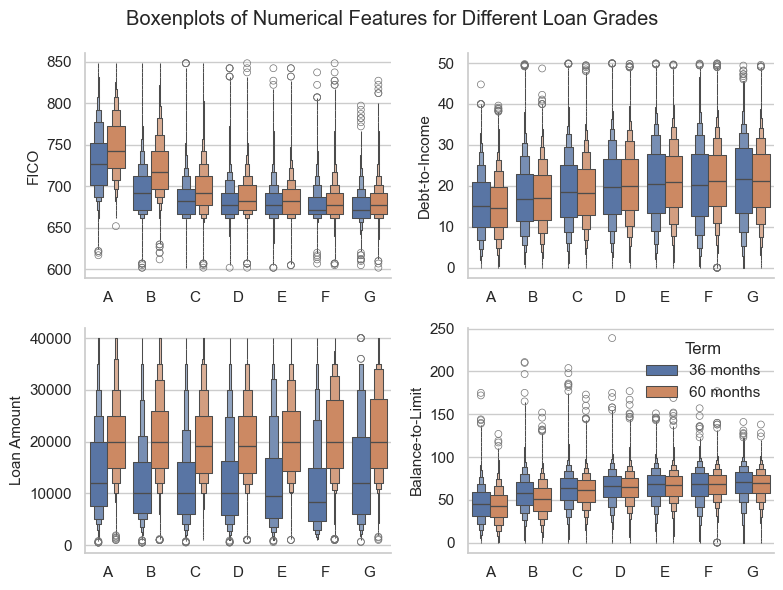

In [21]:
cols = [
    "FICO",
    "Debt-to-Income",
    "Loan Amount",
    "Balance-to-Limit",
]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for idx, col in enumerate(cols):
    sns.boxenplot(
        data=data_eda,
        y=col,
        x="Grade",
        order=grade_labels,
        ax=axes[idx],
        hue="Term",
    )
    axes[idx].set(ylabel=col, xlabel=None)
    if idx < 3:
        axes[idx].get_legend().remove()
fig.suptitle("Boxenplots of Numerical Features for Different Loan Grades")
plt.show()

A higher portion of A and B grades is observed among loans without verified income. The best grades are assigned to credit card and car loans, while worst - small business.

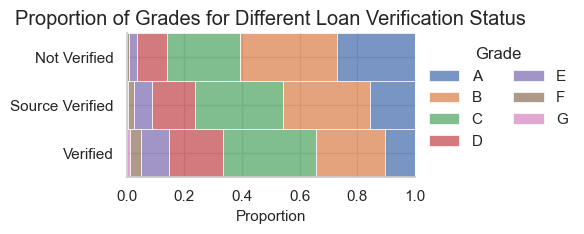

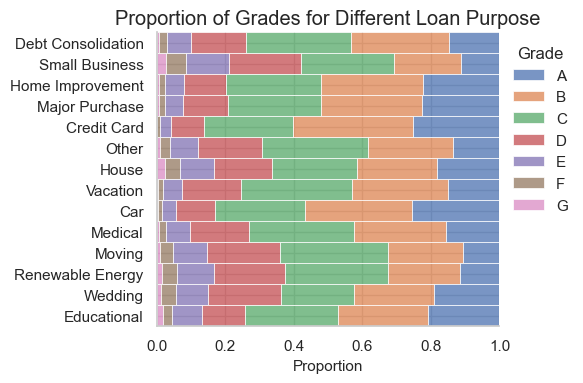

In [22]:
cols = ["Verification Status", "Purpose"]
for idx, col in enumerate(cols):
    if idx == 0:
        plt.figure(figsize=(6, 2.5))
        ncols = 2
    else:
        ncols = 1
    ax = sns.histplot(
        data=data_eda,
        y=col,
        hue="Grade",
        hue_order=grade_labels,
        multiple="fill",
        stat="proportion",
    )
    ax.set(
        title=f"Proportion of Grades for Different Loan {col}",
        ylabel="",
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncols=ncols)
    plt.show()

### 3.5. <a id='toc3_5_'></a>Summary on Exploratory Data Analysis    [&#8593;](#toc0_)

1. Most loans are individual and have a 36-month term, primarily for debt consolidation. 
2. Skewed distributions are observed in numerical columns, particularly those related to time periods and counts.
3. FICO scores, debt-to-income ratio, and bankcard balance-to-limit ratio are related to interest rates.
4. Shorter loan terms typically have smaller interest rates.
5. Interest rates are similar across different loan purposes, but credit card refinancing typically has the lowest median interest rate, while small business loans have the highest. Credit card and car loans are associated with the best loan grades, while small business loans have the worst grades.
6. Joint loans for small business purposes may result in lower interest rates, suggesting a potential benefit for borrowers.
7. Surprisingly, loans from applicants without verified income sources have slightly lower median interest rates. Also, a higher portion of A and B grades is observed among loans without verified income sources.
8. Higher FICO scores are associated with A, B, and C loan grades and longer term. FICO scores do not vary much among lower loan grades (D, E, F, G).
9. Debt-to-income ratio increases slightly with worsening loan grade.
10. A and B grade loans have the smallest median bankcard balance-to-limit ratio.

## 4. <a id='toc4_'></a>Statistical Inference on Joint Applications      [&#8593;](#toc0_)

Joint loans are offered to increase creditworthiness. Hence, it could be thought that joint debt-to-income ratio is lower than 1st applicant's debt-to-income ratio and 2nd applicant's FICO is higher than the 1st applicant's. These assumptions are checked with statistical inference. To begin with, a small dataframe is created with only joint loans containing all necessary information available. The sample size here is more than 100000 loans.

In [23]:
accepted_dataset_file = "./data/accepted_2007_to_2018Q4.csv"
joint_loans = pl.read_csv(
    accepted_dataset_file,
    ignore_errors=True,
    columns=[
        "application_type",
        "dti",
        "dti_joint",
        "fico_range_low",
        "fico_range_high",
        "sec_app_fico_range_low",
        "sec_app_fico_range_high",
    ],
)
joint_loans = joint_loans.drop_nulls().filter(
    (c.application_type == "Joint App") & (c.dti <= 100)
)
joint_loans = joint_loans.with_columns(
    c.sec_app_fico_range_low.cast(pl.Float32),
    c.sec_app_fico_range_high.cast(pl.Float32),
)
joint_loans = joint_loans.with_columns(
    fico1=((c.fico_range_low + c.fico_range_high) / 2).round().cast(pl.Int16),
    fico2=((c.sec_app_fico_range_low + c.sec_app_fico_range_high) / 2)
    .round()
    .cast(pl.Int16),
).drop(
    columns=[
        "application_type",
        "fico_range_low",
        "fico_range_high",
        "sec_app_fico_range_low",
        "sec_app_fico_range_high",
    ]
)
joint_loans = joint_loans.with_columns(
    dti_diff=c.dti - c.dti_joint, fico_diff=c.fico1 - c.fico2
)
joint_loans.describe()

describe,dti,dti_joint,fico1,fico2,dti_diff,fico_diff
str,f64,f64,f64,f64,f64,f64
"""count""",104017.0,104017.0,104017.0,104017.0,104017.0,104017.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",27.453297,19.275952,716.322217,671.732621,8.177345,44.589596
"""std""",17.310136,7.863542,40.39925,44.860901,14.411551,45.77901
"""min""",0.0,0.0,662.0,542.0,-39.05,-130.0
"""25%""",14.98,13.5,682.0,647.0,-0.53,15.0
"""50%""",24.61,18.88,707.0,672.0,5.52,35.0
"""75%""",36.39,24.71,742.0,697.0,14.09,65.0
"""max""",100.0,39.99,848.0,848.0,93.89,301.0


To investigate if borrowers invite second applicants to reduce DTI ratio, difference in the first applicant's DTI and joint DTI is calculated. The null hypothesis is raised that the population mean of the differences of DTIs is zero or less. The alternative hypothesis is that the population mean of the differences is greater than zero. Population here are joint loans accepted by Lending Club. Parameter of interest is the population mean of the differences of DTIs (first applicant's DTI - joint DTI). The significance level of $\alpha=0.05$ is used to calculate the confidence interval and perform a one-sample t-test. 

t-test results are: TtestResult(statistic=183.00113165485962, pvalue=0.0, df=104016)
So the null hypothesis is rejected in favour of the alternative. 
Mean difference with 95% confidence interval is 8.177 (8.09, 8.265).


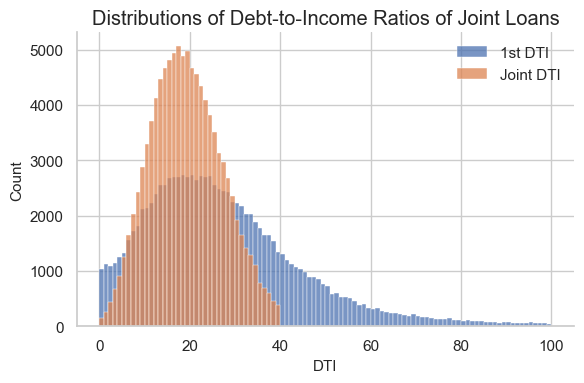

In [24]:
def statistical_inference_1samp(data: np.array, alternative: str) -> None:
    ttest_results = stats.ttest_1samp(
        a=data, popmean=0, alternative=alternative
    )
    mu = np.mean(data)
    ci = stats.t.interval(0.95, len(data) - 1, mu, stats.sem(data))
    ci = tuple([round(x, 3) for x in ci])
    print(f"t-test results are: {ttest_results}")
    if ttest_results.pvalue < 0.05:
        print(
            "So the null hypothesis is rejected in favour of the alternative."
            " \nMean difference with 95% confidence interval is"
            f" {mu:.3f} {ci}."
        )
    else:
        print(
            "So the null hypothesis cannot be rejected in favour of the"
            " alternative. \nMean difference with 95% confidence interval is"
            f" {mu:.3f} {ci}."
        )

    return


statistical_inference_1samp(joint_loans["dti_diff"].to_numpy(), "greater")
sns.histplot(data=joint_loans, x="dti", label="1st DTI", binwidth=1)
sns.histplot(data=joint_loans, x="dti_joint", label="Joint DTI", binwidth=1)
plt.title("Distributions of Debt-to-Income Ratios of Joint Loans")
plt.xlabel("DTI")
plt.legend()
plt.show()

To investigate if second applicant's FICO is higher, difference in the first applicant's and seconds applicant's FICOs is calculated. The null hypothesis is raised that the population mean of the differences of FICOs is zero or more. The alternative hypothesis is that the population mean of the differences is less than zero. Population here are joint loans accepted by Lending Club. Parameter of interest is the population mean of the differences of FICOs (first applicant's FICO - second applicant's FICO). The significance level of $\alpha=0.05$ is used to calculate the confidence interval and perform a one-sample t-test.

t-test results are: TtestResult(statistic=314.1371542226476, pvalue=1.0, df=104016)
So the null hypothesis cannot be rejected in favour of the alternative. 
Mean difference with 95% confidence interval is 44.590 (44.311, 44.868).


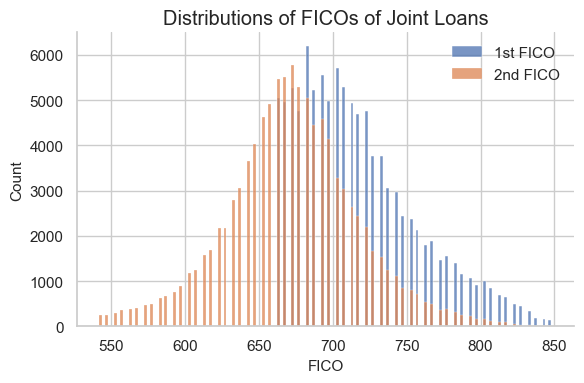

In [25]:
statistical_inference_1samp(joint_loans["fico_diff"].to_numpy(), "less")
sns.histplot(data=joint_loans, x="fico1", label="1st FICO", binwidth=2)
sns.histplot(data=joint_loans, x="fico2", label="2nd FICO", binwidth=2)
plt.title("Distributions of FICOs of Joint Loans")
plt.xlabel("FICO")
plt.legend()
plt.show()

### 4.1. <a id='toc4_1_'></a>Summary on Statistcial Inference   [&#8593;](#toc0_)

1. Indeed, joint DTI on joint loans is lower than the 1st applicant's DTI. Taking out a joint loan may help in meeting Lending Club requirement of debt-to-income ratio being lower than 40%.
2. On the other hand, the 1st applicant's FICO is still higher on average than the 2nd applicants FICO. This indicates, that a coborrower not necessarily has a better credit history. 

## 5. <a id='toc5_'></a>Modeling      [&#8593;](#toc0_)

Following are the features considered for modeling. The selected ones are indicated with a thick mark.

| Feature Name | Description | Grade Model | Subgrade Model | Interest Rate Model |
| :-: | :- | :-: | :-: | :-: |
| grade | LC assigned loan grade |&cross;|&check;|&check;|
| sub_grade | LC assigned loan subgrade |&cross;|&cross;|&cross;|
| int_rate | LC assigned interest rate on the loan |&cross;|&cross;|&cross;|
| fico | The middle of the borrower’s FICO range at loan origination |&check;|&check;|&check;|
| loan_amnt | The listed amount of the loan applied for by the borrower |&check;|&check;|&check;|
| dti | A ratio of the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, and the borrower’s self-reported monthly income |&check;|&check;|&check;|
| inq_last_6mths | The number of inquiries in past 6 months (excluding auto and mortgage inquiries) |&check;|&check;|&check;|
| mths_since_recent_inq | Months since most recent inquiry |&check;|&check;|&check;|
| acc_open_past_24mths | Number of trades opened in past 24 months |&check;|&check;|&check;|
| all_util | Balance to credit limit on all trades |&check;|&check;|&check;|
| bc_util | Ratio of total current balance to high credit/credit limit for all bankcard accounts |&check;|&check;|&check;|
| tot_hi_cred_lim | Total high credit/credit limit |&check;|&check;|&check;|
| total_rev_hi_lim | Total revolving high credit/credit limit |&check;|&check;|&check;|
| bc_open_to_buy | Total open to buy on revolving bankcards |&check;|&check;|&check;|
| mo_sin_old_il_acct | Months since oldest bank installment account opened |&check;|&check;|&cross;|
| mo_sin_old_rev_tl_op | Months since oldest revolving account opened |&check;|&check;|&check;|
| num_tl_op_past_12m | Number of accounts opened in past 12 months |&check;|&check;|&check;|
| purpose | A category provided by the borrower for the loan request |&check;|&check;|&check;|
| term | The number of payments on the loan. Values are in months and can be either 36 or 60 |&check;|&check;|&check;|
| verification_status | Indicates if income was verified by LC, not verified, or if the income source was verified |&check;|&check;|&check;|
| inq_last_12m | Number of credit inquiries in past 12 months |&cross;|&check;|&check;|
| mths_since_last_record | The number of months since the last public record |&cross;|&check;|&check;|
| num_actv_rev_tl | Number of currently active revolving trades |&cross;|&check;|&check;|
| pct_tl_nvr_dlq | Percent of trades never delinquent |&cross;|&check;|&check;|
| open_il_12m | Number of installment accounts opened in past 12 months |&cross;|&check;|&check;|
| application_type | Indicates whether the loan is an individual application or a joint application with two co-borrowers |&cross;|&cross;|&check;|
| mort_acc | Number of mortgage accounts |&cross;|&check;|&check;|
| home_ownership | The home ownership status provided by the borrower during registration or obtained from the credit report |&cross;|&check;|&cross;|
| | Total number of features |17|25|24|


### 5.1. <a id='toc5_1_'></a>Grade Prediction      [&#8593;](#toc0_)

As a starting point for the task of predicting loan grade, different models are tested with `lazypredict` (see `lazy_prediction_grade.ipynb` notebook). The regression approach is also tried out to this ordered classification task. However, classifiers performs better in general. Since LGBMClassifier yields lowest macro-averaged MAE and highest F1 score, it is chosen for tuning (see `tuning_acceptance.ipynb`). The number of maximum features selected for this model is 17. The obtained classifier has 138 estimators with maximum depth of 10 and maximum number of leaves set to 63. This parameter was limited to prevent overfitting to the validation set. Since LGBMClassifier can natively deal with categorical features and missing values, it reduces the burden of feature encoding and imputations.

In [26]:
grade_model = joblib.load("./tuned_models/grade_model.joblib")
grade_model

Pipeline(steps=[('selector',
                 SelectFromModel(estimator=LGBMClassifier(random_state=42,
                                                          verbose=-1),
                                 max_features=17, prefit=True,
                                 threshold=-inf)),
                ('estimator',
                 LGBMClassifier(callbacks=None, class_weight='balanced',
                                early_stopping_rounds=None, max_depth=10,
                                metric='custom',
                                min_child_weight=405.8769103685436,
                                n_estimators=138, n_jobs=4, num_class=7,
                                num_leaves=63, objective='multiclass',
                                random_state=42, reg_alpha=0.000790754976515777,
                                reg_lambda=0.0038071919424446836, subsample=0.5,
                                verbosity=-1))])

The macro-averaged mean absolute error is 0.92 on validation set and 1.22 on test set. The weighted average F1 scores for all classes is 0.48 on validation set and 0.44 on test set. The reduction in performance metrics may indicate model overfitting to the validation set. The worst performance is seen for E, F, and G loan grades possibly due to low training sample of these loans. Note, however, that these final models are already fitted on joint training and validation sets.

VALIDATION SET 
Macro-averaged mean absolute error:  0.92
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

          A       0.69      0.79      0.88      0.73      0.83      0.69     59785
          B       0.50      0.47      0.80      0.49      0.62      0.37     70728
          C       0.46      0.36      0.85      0.40      0.55      0.29     64259
          D       0.33      0.24      0.92      0.28      0.47      0.21     33921
          E       0.16      0.15      0.97      0.16      0.39      0.14      8040
          F       0.07      0.38      0.97      0.12      0.61      0.35      1605
          G       0.02      0.80      0.95      0.04      0.87      0.75       298

avg / total       0.50      0.48      0.86      0.48      0.62      0.40    238636



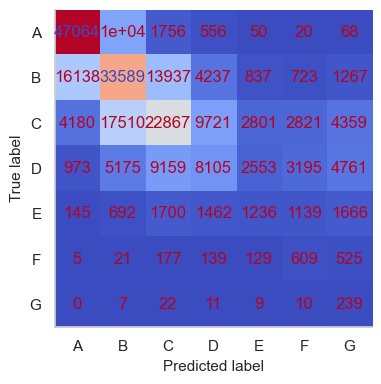

TEST SET 
Macro-averaged mean absolute error:  1.22
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

          A       0.67      0.65      0.87      0.66      0.75      0.55     75392
          B       0.39      0.44      0.74      0.41      0.57      0.31     70637
          C       0.39      0.34      0.83      0.36      0.53      0.27     62591
          D       0.31      0.22      0.92      0.26      0.45      0.19     35125
          E       0.15      0.10      0.97      0.12      0.32      0.09     10918
          F       0.04      0.20      0.97      0.06      0.44      0.18      1570
          G       0.01      0.39      0.96      0.03      0.61      0.35       373

avg / total       0.45      0.43      0.84      0.44      0.59      0.35    256606



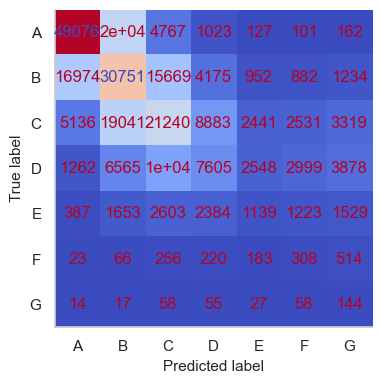

In [27]:
y_val, y_val_pred, y_test, y_test_pred = prepare_data_evaluation(
    grade_model,
    pd.read_pickle("./data/data_val_mod2.pkl"),
    pd.read_pickle("./data/data_test_mod2.pkl"),
    target="grade_enc",
    drop_cols=["sub_grade", "int_rate", "sub_grade_enc", "grade"],
)
print(
    "VALIDATION SET \nMacro-averaged mean absolute error: "
    f" {macro_averaged_mean_absolute_error(y_val,y_val_pred):.2f}"
)
print_classification_results(y_val, y_val_pred, labels=grade_labels)
print(
    "TEST SET \nMacro-averaged mean absolute error: "
    f" {macro_averaged_mean_absolute_error(y_test,y_test_pred):.2f}"
)
print_classification_results(y_test, y_test_pred, labels=grade_labels)

Term, FICO, DTI, loan amount, and purpose are features more or less important for all grade classification.

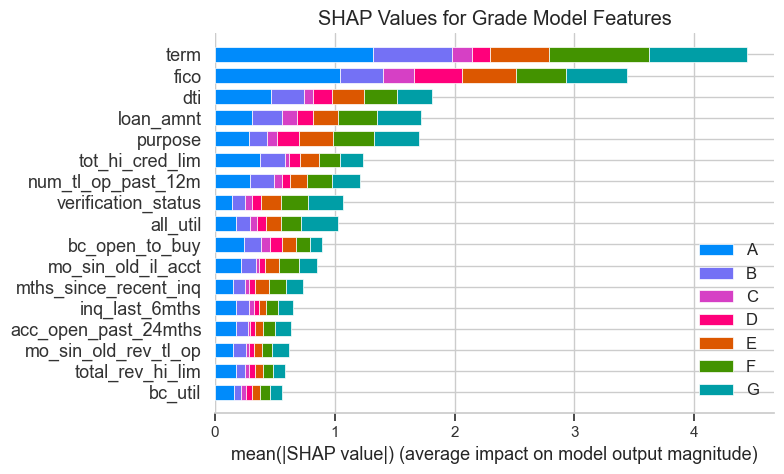

In [28]:
X_shap, _ = (
    pd.read_pickle("./data/data_test_mod2.pkl")
    .pipe(stratified_sample, frac=0.01, col="sub_grade")
    .drop(columns=["grade", "int_rate", "sub_grade", "sub_grade_enc"])
    .pipe(X_y_spilt, target="grade_enc")
)
plot_shap_values(
    model=grade_model.named_steps["estimator"],
    data=X_shap,
    processor=Pipeline(grade_model.steps[:-1]),
    labels=grade_labels,
    title="SHAP Values for Grade Model Features",
    bar_height=0.2,
)

### 5.2. <a id='toc5_2_'></a>Subgrade      [&#8593;](#toc0_)

As a starting point for the task of predicting loan subgrade, different models are tested with `lazypredict` (see `lazy_prediction_subgrade.ipynb` notebook). The regression approach is also tried out to this ordered classification task. However, classifiers performs better in general. True grade is also used as a feature for this model. Since LGBMClassifier yields lowest macro-averaged MAE and highest F1 score, it is chosen for tuning (see `tuning_subgrade.ipynb`). The tuning is performed on downsampled data to not allow classifier focus on majority classes. The number of maximum features selected for this model is 25. The obtained classifier has 32 estimators with maximum depth of 27 and maximum number of leaves set to 92. 

In [29]:
subgrade_model = joblib.load("./tuned_models/subgrade_model.joblib")
subgrade_model

Pipeline(steps=[('selector',
                 SelectFromModel(estimator=LGBMClassifier(random_state=42,
                                                          verbose=-1),
                                 max_features=25, prefit=True,
                                 threshold=-inf)),
                ('estimator',
                 LGBMClassifier(callbacks=None,
                                colsample_bytree=0.7000000000000001,
                                early_stopping_rounds=None, max_depth=27,
                                metric='auc_mu',
                                min_child_weight=83.15066979556568,
                                n_estimators=32, n_jobs=-1, num_class=35,
                                num_leaves=92, objective='multiclass',
                                random_state=42, reg_alpha=0.4031740266872948,
                                reg_lambda=0.034111358234840586,
                                subsample=0.7000000000000001, verbosity=-1))])

The macro-averaged mean absolute error is 1.44 on validation set and 1.51 on test set. The weighted average F1 scores for all classes is 0.24 on validation set. Hyperparameter tuning did not bring any significant improve to model performance. Performance of subgrade model on test set is presented for each grade separately. Note, however, that these final models are already fitted on joint training and validation sets.
|Grade|Macro-averaged MAE|Weighted average F1 score|
|:-:|:-:|:-:|
|A|1.47|0.25|
|B|1.57|0.21|
|C|1.61|0.22|
|D|1.47|0.22|
|E|1.29|0.29|
|F|1.61|0.28|
|G|1.53|0.42|

In [30]:
y_val, y_val_pred, y_test, y_test_pred = prepare_data_evaluation(
    subgrade_model,
    pd.read_pickle("./data/data_val_mod2.pkl"),
    pd.read_pickle("./data/data_test_mod2.pkl"),
    target="sub_grade_enc",
    drop_cols=["sub_grade", "int_rate", "grade_enc"],
)
print(
    "VALIDATION SET \nMacro-averaged mean absolute error: "
    f" {macro_averaged_mean_absolute_error(y_val,y_val_pred):.2f}"
)
print_classification_results(
    y_val, y_val_pred, labels=subgrade_labels, show_cm=False
)
print(
    "TEST SET \nMacro-averaged mean absolute error: "
    f" {macro_averaged_mean_absolute_error(y_test,y_test_pred):.2f}"
)

VALIDATION SET 
Macro-averaged mean absolute error:  1.44
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         A1       0.33      0.57      0.95      0.42      0.73      0.52     10746
         A2       0.24      0.23      0.96      0.23      0.47      0.21     11040
         A3       0.25      0.19      0.97      0.21      0.42      0.17     12545
         A4       0.27      0.14      0.98      0.18      0.37      0.13     13910
         A5       0.31      0.39      0.96      0.35      0.61      0.35     11544
         B1       0.30      0.53      0.92      0.38      0.70      0.46     14728
         B2       0.25      0.21      0.96      0.22      0.44      0.18     14672
         B3       0.16      0.09      0.98      0.12      0.30      0.08     11685
         B4       0.23      0.11      0.98      0.15      0.33      0.10     14467
         B5       0.28      0.34      0.94      0.31      0.57      0.30     15176
   


Macro-averaged mean absolute error:  1.47
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         A1       0.36      0.37      0.79      0.36      0.54      0.28     18141
         A2       0.19      0.19      0.85      0.19      0.40      0.15     11831
         A3       0.20      0.16      0.87      0.18      0.37      0.13     12719
         A4       0.25      0.12      0.88      0.16      0.33      0.10     17738
         A5       0.27      0.47      0.68      0.34      0.57      0.31     14963

avg / total       0.26      0.27      0.81      0.25      0.45      0.20     75392



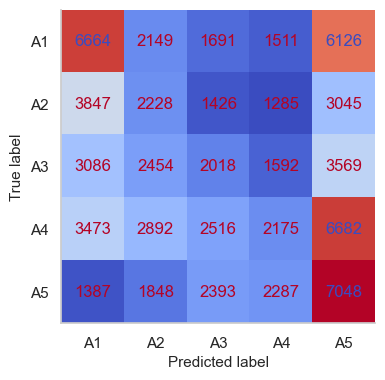


Macro-averaged mean absolute error:  1.57
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         B1       0.25      0.49      0.66      0.33      0.57      0.32     13309
         B2       0.22      0.19      0.83      0.20      0.39      0.14     14858
         B3       0.15      0.10      0.90      0.12      0.29      0.08     11491
         B4       0.26      0.10      0.91      0.14      0.30      0.08     17261
         B5       0.24      0.33      0.75      0.28      0.50      0.23     13718

avg / total       0.23      0.24      0.81      0.21      0.41      0.17     70637



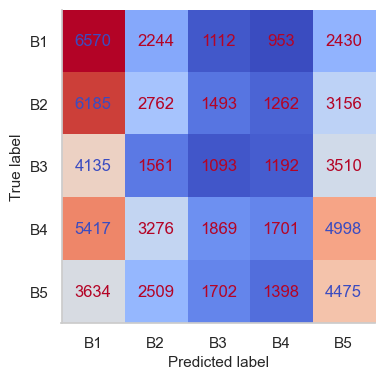


Macro-averaged mean absolute error:  1.61
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         C1       0.26      0.38      0.69      0.31      0.51      0.26     14021
         C2       0.20      0.14      0.87      0.16      0.35      0.11     12251
         C3       0.21      0.14      0.86      0.17      0.35      0.11     13401
         C4       0.20      0.17      0.85      0.18      0.38      0.13     11595
         C5       0.21      0.28      0.76      0.24      0.46      0.20     11323

avg / total       0.22      0.23      0.80      0.22      0.41      0.17     62591



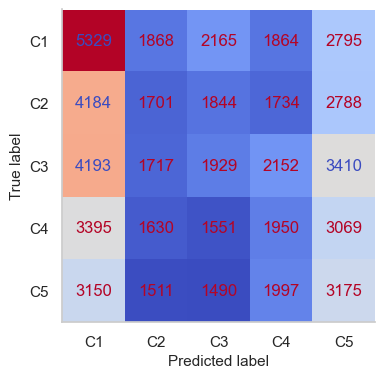


Macro-averaged mean absolute error:  1.47
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         D1       0.29      0.25      0.80      0.27      0.45      0.19      8550
         D2       0.23      0.26      0.74      0.24      0.44      0.18      8028
         D3       0.21      0.27      0.73      0.24      0.44      0.19      7269
         D4       0.21      0.12      0.90      0.15      0.32      0.10      6199
         D5       0.19      0.20      0.85      0.19      0.41      0.16      5079

avg / total       0.23      0.23      0.80      0.22      0.42      0.17     35125



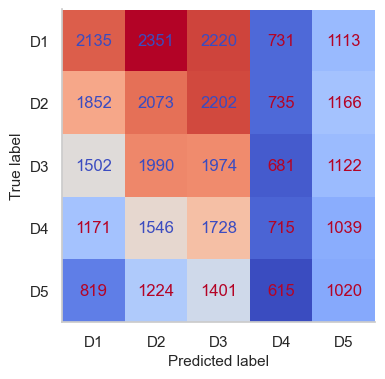


Macro-averaged mean absolute error:  1.29
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         E1       0.41      0.31      0.84      0.36      0.51      0.25      2860
         E2       0.23      0.38      0.75      0.29      0.53      0.27      1819
         E3       0.19      0.13      0.88      0.15      0.34      0.10      1975
         E4       0.19      0.10      0.92      0.13      0.30      0.08      1699
         E5       0.37      0.50      0.73      0.42      0.61      0.36      2565

avg / total       0.30      0.30      0.82      0.29      0.47      0.23     10918



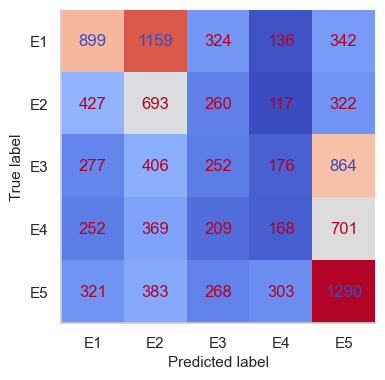


Macro-averaged mean absolute error:  1.61
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         F1       0.48      0.41      0.70      0.44      0.53      0.27       640
         F2       0.20      0.14      0.83      0.17      0.35      0.11       360
         F3       0.18      0.16      0.87      0.17      0.37      0.13       245
         F4       0.13      0.12      0.90      0.12      0.33      0.10       162
         F5       0.12      0.31      0.75      0.18      0.48      0.22       163

avg / total       0.30      0.27      0.78      0.28      0.44      0.19      1570



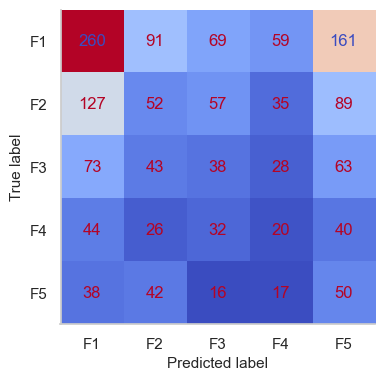


Macro-averaged mean absolute error:  1.53
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

         G1       0.80      0.43      0.83      0.56      0.60      0.34       231
         G2       0.47      0.20      0.95      0.28      0.43      0.17        71
         G3       0.11      0.16      0.88      0.13      0.37      0.13        32
         G4       0.05      0.29      0.74      0.09      0.47      0.21        17
         G5       0.08      0.27      0.80      0.12      0.47      0.21        22

avg / total       0.60      0.35      0.85      0.42      0.53      0.28       373



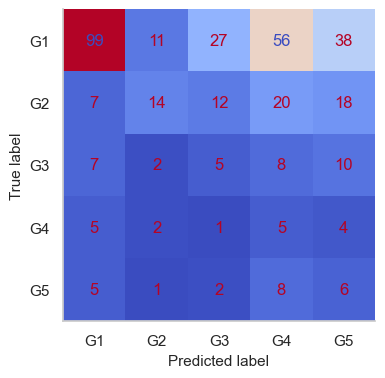

In [31]:
for grade in range(7):
    cl = 5 * grade
    idx = y_test[(y_test >= cl) & (y_test <= cl + 4)].index
    print(
        "\nMacro-averaged mean absolute error: "
        f" {macro_averaged_mean_absolute_error(y_test[idx],y_test_pred[idx]):.2f}"
    )
    print_classification_results(
        y_test[idx],
        y_test_pred[idx],
        labels=subgrade_labels[cl : cl + 5],
        normalize=None,
    )

Because of high number of class, the SHAP plot would be overcrowded. Feature importance plot from LGBMClassifier shows that apart of grade, term and FICO are important features for subgrade prediction.

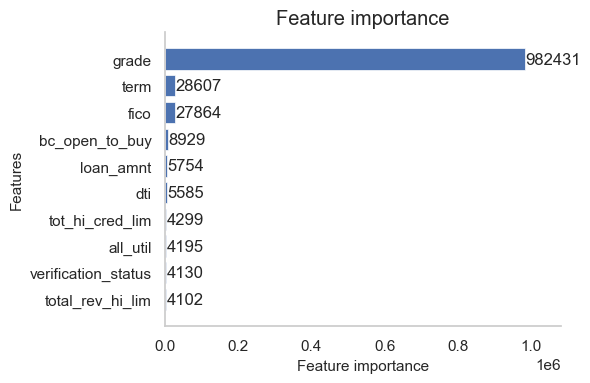

In [32]:
lgbm.plot_importance(
    subgrade_model.named_steps["estimator"],
    height=0.8,
    grid=False,
    ignore_zero=False,
    importance_type="gain",
    max_num_features=10,
    precision=0,
)
plt.show()

### 5.3. <a id='toc5_3_'></a>Interest Rate      [&#8593;](#toc0_)

As a starting point for the task of predicting loan interest rate, different models are tested with `lazypredict` (see `lazy_prediction_rate.ipynb` notebook). True grade is also used as a feature for this model. Since LGBMRegressor yields lowest root mean squared error, it is chosen for tuning (see `tuning_rate.ipynb`). The number of maximum features selected for this model is 24. The obtained regressor has 320 estimators with maximum depth of 25 and maximum number of leaves set to 22.

In [33]:
rate_model = joblib.load("./tuned_models/rate_model.joblib")
rate_model

Pipeline(steps=[('selector',
                 SelectFromModel(estimator=LGBMRegressor(random_state=42,
                                                         verbose=-1),
                                 max_features=24, prefit=True,
                                 threshold=-inf)),
                ('estimator',
                 LGBMRegressor(callbacks=None, early_stopping_rounds=None,
                               max_depth=25, metric='rmse',
                               min_child_weight=480.1075614827911,
                               n_estimators=320, n_jobs=4, num_leaves=22,
                               objective='regression', random_state=42,
                               reg_alpha=0.0014653150149294624,
                               reg_lambda=0.00012150145206575937, subsample=0.9,
                               verbosity=-1))])

Model yields RMSE of 1.14 on validation set and 1.39 on test set. There are clusters in predictions due to grade feature, which is very important predictor of interest rate. High residuals are produced by unexpectedly low interest rates for low quality loans. Variance increases with higher interest rates. High interest rates are less common and the model got a relatively small samples of those to learn from. Note, however, that these final models are already fitted on joint training and validation sets.

VALIDATION SET
RMSE = 1.14, R^2 = 0.949


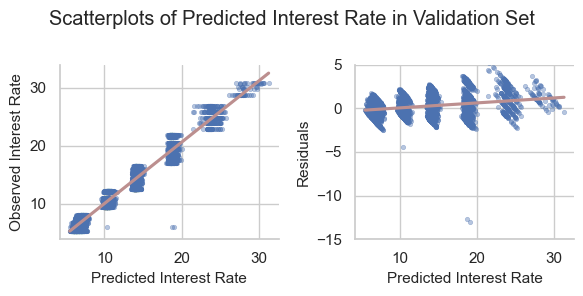

TEST SET
RMSE = 1.392, R^2 = 0.929


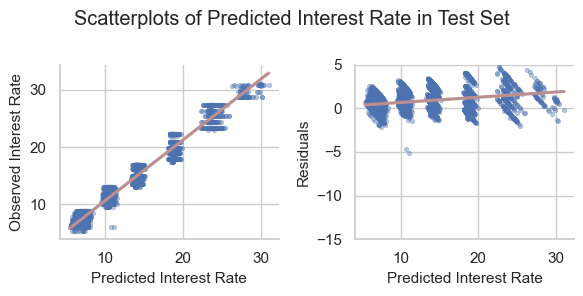

In [34]:
y_val, y_val_pred, y_test, y_test_pred = prepare_data_evaluation(
    rate_model,
    pd.read_pickle("./data/data_val_mod2.pkl"),
    pd.read_pickle("./data/data_test_mod2.pkl"),
    target="int_rate",
    drop_cols=["sub_grade", "sub_grade_enc", "grade_enc"],
)
print("VALIDATION SET")
fig = print_regression_results(
    y_val, y_val_pred, "Interest Rate", ylim=(-15, 5)
)
fig.suptitle("Scatterplots of Predicted Interest Rate in Validation Set")
fig.set_figheight(3)
plt.show()
print("TEST SET")
fig = print_regression_results(
    y_test, y_test_pred, "Interest Rate", ylim=(-15, 5)
)
fig.suptitle("Scatterplots of Predicted Interest Rate in Test Set")
fig.set_figheight(3)
plt.show()

SHAP values for the regressor again show that garde was the most important predictor of the interest rate. It was also determined by number of installment accounts opened in past 12 months, term, FICO, and other features.

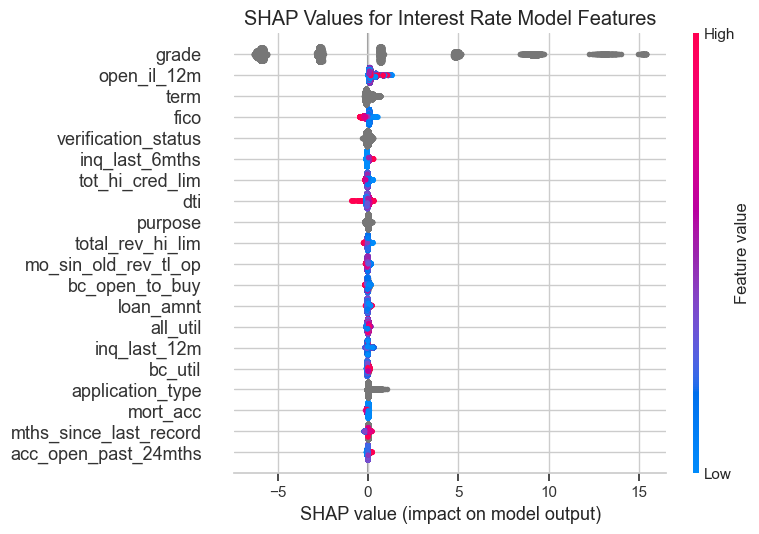

In [35]:
X_shap, _ = (
    pd.read_pickle("./data/data_test_mod2.pkl")
    .pipe(stratified_sample, frac=0.1, col="sub_grade")
    .drop(columns=["sub_grade", "sub_grade_enc", "grade_enc"])
    .pipe(X_y_spilt, target="int_rate")
)
plot_shap_values(
    model=rate_model.named_steps["estimator"],
    data=X_shap,
    processor=Pipeline(rate_model.steps[:-1]),
    title="SHAP Values for Interest Rate Model Features",
    bar_height=0.2,
)

### 5.4. <a id='toc5_4_'></a>Deployment   [&#8593;](#toc0_)

Grade model is saved for deployment without feature selector as it will simplify the request schema.

In [36]:
grade_model = joblib.load("./tuned_models/grade_model.joblib")
grade_clf = Pipeline(grade_model.steps[1:])
joblib.dump(grade_clf, "./deployment/grade_model_deploy.joblib")

['./deployment/grade_model_deploy.joblib']

Loan grade model is part of Lending Club service deployed at GCP. It can be reached via link at: https://lending-club-service-c4gigp2h5q-lm.a.run.app. To test the response of the model, a correctly formatted json can be provided at https://lending-club-service-c4gigp2h5q-lm.a.run.app/docs#/default/predict_predict_grade_post. Schema example:

In [37]:
grade_feat = grade_model[:-1].get_feature_names_out()
sample = pd.read_pickle("./data/data_test_mod2.pkl")[grade_feat].sample(n=1)
print(sample.to_json(orient="records").replace(":null", ':"nan"').strip("[]"))

{"loan_amnt":37800.0,"term":"60 months","verification_status":"Not Verified","purpose":"credit_card","dti":13.15,"inq_last_6mths":0.0,"all_util":79.0,"total_rev_hi_lim":48100.0,"acc_open_past_24mths":0.0,"bc_open_to_buy":5523.0,"bc_util":82.0,"mo_sin_old_il_acct":196.0,"mo_sin_old_rev_tl_op":224.0,"mths_since_recent_inq":"nan","num_tl_op_past_12m":0.0,"tot_hi_cred_lim":121548.0,"fico":702.0}


Subgrade and rate models are deployed with feature selectors as they are executed with the same request. That means that interest rate is predicted without knowing the subgrade, only the loan grade. Loan subgrade and interest rate models are also part of Lending Club service deployed at GCP. To test the response of the models, a correctly formatted json can be provided at https://lending-club-service-c4gigp2h5q-lm.a.run.app/docs#/default/predict_predict_subgrade_rate_post. Schema example:

In [38]:
sample = (
    pd.read_pickle("./data/data_test_mod2.pkl")
    .drop(columns=["sub_grade", "sub_grade_enc", "int_rate", "grade_enc"])
    .sample(n=1)
)
print(sample.to_json(orient="records").replace(":null", ':"nan"').strip("[]"))

{"loan_amnt":24000.0,"term":"36 months","grade":"A","home_ownership":"RENT","verification_status":"Verified","purpose":"debt_consolidation","dti":17.52,"inq_last_6mths":0.0,"mths_since_last_record":"nan","application_type":"Individual","open_il_12m":0.0,"all_util":22.0,"total_rev_hi_lim":39500.0,"inq_last_12m":0.0,"acc_open_past_24mths":3.0,"bc_open_to_buy":30960.0,"bc_util":21.6,"mo_sin_old_il_acct":31.0,"mo_sin_old_rev_tl_op":52.0,"mort_acc":0.0,"mths_since_recent_inq":14.0,"num_actv_rev_tl":4.0,"num_tl_op_past_12m":0.0,"pct_tl_nvr_dlq":100.0,"tot_hi_cred_lim":81441.0,"fico":747.0}


The deployment can be also tested with locust by running `locust -f deployment/locust_test.py`.

### 5.5. <a id='toc5_5_'></a>Summary on Modeling [&#8593;](#toc0_)

1. After trying out different algorithms at first, LGBM models were selected to tune for all tasks.
2. To evaluate grade and subgrade models, macro-averaged mean absolute error was used to account for different distances between grades and subgrades. However, this metric was not suitable for subgrade model tuning as the middle subgrade of each grade were predicted mostly. In this case, using balanced dataset instead of class weights helped more.
3. Weighted F1 score of 0.44 is achieved on test set for grade prediction. Higher grades of A, B, and C are predicted better than lower grades. Macro-averaged mean absolute error of 1.22 grade is achieved.
4. Weighted F1 score of 0.24 is achieved on validation set for overall subgrade prediction. On test set, for grades A through G, this metric is lowest for B grades (0.21) and highest for G grades (0.42). Overall macro-averaged mean absolute error of 1.51 subgrade is achieved on test set. This metric is best for E subgrades (1.29), and worst for C and F subgrades (1.61).
5. Root mean square error of 1.39 percentage points is achieved for interest rate prediction on test set. The variance and bias of residuals slightly increases with higher interest rates. High residuals might be expected in cases where low interest rates are given to poor quality loans.


## 6. <a id='toc6_'></a>Recommendations      [&#8593;](#toc0_)

* Model predicted grades, subgrades and interest rates should be checked by knowledgeable experts to avoid potential pitfalls as correctly predicting these loan metrics seems as a rather difficult task.
* It is very important to distinguish which information is available at loan origination. That can influence features possible to use for grade, subgrade and interest rate prediction. 
* Information on term, FICO, debt-to-income ratio, loan amount, purpose,  total high credit/credit limit, number of accounts opened in past 12 months, balance to credit limit and other financial metrics help in predicting loan grades.
* Apart of grade, term, FICO, available credit on revolving bankcards, loan amount, debt-to-income ratio, total high credit/credit limit, balance to credit limit and other metrics help in predicting loan subgrades.
* Apart of grade, number of installment accounts opened in past 12 months, term, FICO, the number of inquiries in past 6 months, total high credit/credit limit, debt-to-income ratio, loan purpose, etc., can help in predicting loan grades.
* If interest rate prediction can be performed after determining loan subgrade, this additional information could potentially improve interest rate prediction.
* The company could pay more attention to coborrower's FICO as it tend to be higher than that of the 1st applicant's.

## 7. <a id='toc7_'></a>Suggestions for Improvement [&#8593;](#toc0_)

* More sophisticated feature engineering could potentially help with more accurate predictions. Also, initial feature selection could be based on different metrics, since checking direct relationships could reject features potentially useful in combination with other features.
* Data samples could be weighted based on their novelty to enhance model performance for the future. Also, training could be limited to the more recent data.
* Individual grade-specific models could be developed to better predict subgrades.
* Cross-validation or separate hold-out set for hyperparameter tuning could be used to avoid potential overfitting on validation set. 
* Metrics, potentially better representing business problem could be searched for and used. 
* Performance of the trained model could be checked on different test months to see if it is diverging.

----
**Lesson learned.** Spending too much time on small details and hyperparameter tuning impedes progress a lot. It also reduces time available to correct errors and mistakes met later in the project. 

**Tools learned.** `polars`, `optuna`, `Docker`, `fastapi`, `GoogleCloud`